In [1]:
!pip install torch torchvision datasets
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-pz1r0ppw
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-pz1r0ppw
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 616.0 kB/s eta 0:00:000:00:01
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=88b3dc90cd8b92d9a99ac9e133c0fac88e71345f1338fc20428b3b23d7c7613b
  Stored in directory: /tmp/pip-ephem-wheel-cache-73r3paxf/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [2]:
from datasets import load_dataset
import clip
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [9]:
model, preprocess = clip.load("ViT-B/16", device = device, jit=False)

100%|███████████████████████████████████████| 335M/335M [00:04<00:00, 86.8MiB/s]


In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
ds = load_dataset("aggr8/brain_mri_train_test_split")

text_prompts = ["a photo of glioma tumor", "a photo of meningioma tumor", "a photo of no tumor", "a photo of pituitary tumor"]

class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = preprocess(self.images[idx])
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


class CustomImageDatasetTrain(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = clip.tokenize([text_prompts[label] for label in labels])
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = preprocess(self.images[idx])
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

transformations = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

dataset = CustomImageDatasetTrain(ds["train"]["image"], ds["train"]["label"], transform=transformations)
train_dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

test_dataset = CustomImageDataset(ds["test"]["image"], ds["test"]["label"])
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

test_dataset_2 = CustomImageDataset(ds["train"]["image"], ds["train"]["label"])
test_dataloader_2 = DataLoader(test_dataset_2, batch_size=32, shuffle=False)

In [34]:
import torch
import torch.nn as nn
import math
from torch.nn import Dropout
from transformers import CLIPModel

class PromptedTransformer(nn.Module):
    def __init__(self, prompt_config, vision_model, img_size):
        super(PromptedTransformer, self).__init__()

        self.prompt_config = prompt_config
        self.vision_model = vision_model
        img_size = (img_size, img_size)

        num_tokens = self.prompt_config["NUM_TOKENS"]
        self.num_tokens = num_tokens  
        self.prompt_dropout = Dropout(self.prompt_config["DROPOUT"])

        prompt_dim = vision_model.config.hidden_size if self.prompt_config["PROJECT"] == -1 else self.prompt_config["PROJECT"]
        self.prompt_proj = nn.Linear(prompt_dim, vision_model.config.hidden_size) if self.prompt_config["PROJECT"] > -1 else nn.Identity()

        # prompt embeddings
        val = math.sqrt(6. / float(3 * img_size[0] * img_size[1] + prompt_dim))
        self.prompt_embeddings = nn.Parameter(torch.zeros(1, num_tokens, prompt_dim))
        nn.init.uniform_(self.prompt_embeddings.data, -val, val)

        if self.prompt_config.get("DEEP", False):
            total_d_layer = vision_model.config.num_hidden_layers  # Use the number of transformer layers in the pre-trained model
            self.deep_prompt_embeddings = nn.ParameterList([
                nn.Parameter(torch.zeros(1, num_tokens, prompt_dim)) for _ in range(total_d_layer)
            ])
            for prompt_embedding in self.deep_prompt_embeddings:
                nn.init.uniform_(prompt_embedding.data, -val, val)
        else:
            self.deep_prompt_embeddings = None

    def incorporate_prompt(self, x, layer_idx):
        B = x.shape[0]

        if self.deep_prompt_embeddings:
            prompts = self.deep_prompt_embeddings[layer_idx].expand(B, -1, -1)
        else:
            prompts = self.prompt_embeddings.expand(B, -1, -1)

        x = torch.cat((
            x[:, :1, :],  # CLS token
            self.prompt_dropout(self.prompt_proj(prompts)),  # inserting Prompts in between CLS and Patches
            x[:, 1:, :]  # Patches
        ), dim=1)
        return x

    def forward(self, pixel_values, attention_mask=None, causal_attention_mask=None):
        hidden_states = self.vision_model.embeddings(pixel_values)
        B = hidden_states.shape[0]

        for layer_idx, layer in enumerate(self.vision_model.encoder.layers):
            hidden_states = self.incorporate_prompt(hidden_states, layer_idx)  
            hidden_states = layer(hidden_states, attention_mask=attention_mask, causal_attention_mask=causal_attention_mask)[0]

        return hidden_states


class CLIP_VPT_Classifier(nn.Module):
    def __init__(self, clip_model_name: str, num_classes: int, prompt_cfg):
        super(CLIP_VPT_Classifier, self).__init__()
        self.clip_model = CLIPModel.from_pretrained(clip_model_name)

        for param in self.clip_model.parameters():
            param.requires_grad = False

        self.prompted_vit = PromptedTransformer(prompt_cfg, self.clip_model.vision_model, img_size=224)
        self.head = nn.Linear(self.clip_model.vision_model.config.hidden_size, num_classes)
        nn.init.kaiming_normal_(self.head.weight, a=0, mode='fan_out')

    def forward(self, pixel_values, attention_mask=None, causal_attention_mask=None):
        encoded = self.prompted_vit(pixel_values, attention_mask=attention_mask, causal_attention_mask=causal_attention_mask)
        cls_token_output = encoded[:, 0] 
        logits = self.head(cls_token_output)

        return logits


num_classes = 4 
prompt_cfg = {
    "NUM_TOKENS": 5,     
    "DROPOUT": 0.1,      
    "PROJECT": -1,      
    "INITIATION": "random",  
    "DEEP": True        
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft = CLIP_VPT_Classifier(clip_model_name="openai/clip-vit-base-patch16", num_classes=num_classes, prompt_cfg=prompt_cfg).to(device)


In [36]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ft.parameters(), lr=1e-2)

Epoch 1/50, Loss: 10.4879: 100%|██████████| 15/15 [00:15<00:00,  1.01s/it]


Epoch [1/50], Loss: 10.4879, Training Accuracy: 28.54%
Validation Accuracy: 23.44%
Best model saved with accuracy 23.44%


Epoch 2/50, Loss: 2.2782: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [2/50], Loss: 2.2782, Training Accuracy: 27.50%
Validation Accuracy: 30.00%
Convergence Speed - Training Accuracy: -1.0417, Validation Accuracy: 6.5625
Convergence Speed - Training Loss: 8.2096, Validation Loss: 0.5799
Best model saved with accuracy 30.00%


Epoch 3/50, Loss: 1.4527: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


Epoch [3/50], Loss: 1.4527, Training Accuracy: 35.21%
Validation Accuracy: 33.75%
Convergence Speed - Training Accuracy: 7.7083, Validation Accuracy: 3.7500
Convergence Speed - Training Loss: 0.8256, Validation Loss: 0.2902
Best model saved with accuracy 33.75%


Epoch 4/50, Loss: 1.3388: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [4/50], Loss: 1.3388, Training Accuracy: 35.42%
Validation Accuracy: 47.50%
Convergence Speed - Training Accuracy: 0.2083, Validation Accuracy: 13.7500
Convergence Speed - Training Loss: 0.1138, Validation Loss: 0.0972
Best model saved with accuracy 47.50%


Epoch 5/50, Loss: 1.2668: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [5/50], Loss: 1.2668, Training Accuracy: 41.67%
Validation Accuracy: 38.44%
Convergence Speed - Training Accuracy: 6.2500, Validation Accuracy: -9.0625
Convergence Speed - Training Loss: 0.0720, Validation Loss: -0.0814


Epoch 6/50, Loss: 1.3296: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [6/50], Loss: 1.3296, Training Accuracy: 42.50%
Validation Accuracy: 42.19%
Convergence Speed - Training Accuracy: 0.8333, Validation Accuracy: 3.7500
Convergence Speed - Training Loss: -0.0628, Validation Loss: 0.0848


Epoch 7/50, Loss: 1.3244: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [7/50], Loss: 1.3244, Training Accuracy: 40.42%
Validation Accuracy: 41.88%
Convergence Speed - Training Accuracy: -2.0833, Validation Accuracy: -0.3125
Convergence Speed - Training Loss: 0.0051, Validation Loss: -0.0026


Epoch 8/50, Loss: 1.3670: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [8/50], Loss: 1.3670, Training Accuracy: 39.38%
Validation Accuracy: 53.75%
Convergence Speed - Training Accuracy: -1.0417, Validation Accuracy: 11.8750
Convergence Speed - Training Loss: -0.0426, Validation Loss: 0.1581
Best model saved with accuracy 53.75%


Epoch 9/50, Loss: 1.2819: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [9/50], Loss: 1.2819, Training Accuracy: 44.58%
Validation Accuracy: 51.56%
Convergence Speed - Training Accuracy: 5.2083, Validation Accuracy: -2.1875
Convergence Speed - Training Loss: 0.0851, Validation Loss: -0.0372


Epoch 10/50, Loss: 1.2958: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [10/50], Loss: 1.2958, Training Accuracy: 43.54%
Validation Accuracy: 57.50%
Convergence Speed - Training Accuracy: -1.0417, Validation Accuracy: 5.9375
Convergence Speed - Training Loss: -0.0139, Validation Loss: 0.1048
Best model saved with accuracy 57.50%


Epoch 11/50, Loss: 1.2695: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [11/50], Loss: 1.2695, Training Accuracy: 42.29%
Validation Accuracy: 55.94%
Convergence Speed - Training Accuracy: -1.2500, Validation Accuracy: -1.5625
Convergence Speed - Training Loss: 0.0263, Validation Loss: -0.0099


Epoch 12/50, Loss: 1.1683: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [12/50], Loss: 1.1683, Training Accuracy: 47.92%
Validation Accuracy: 60.00%
Convergence Speed - Training Accuracy: 5.6250, Validation Accuracy: 4.0625
Convergence Speed - Training Loss: 0.1012, Validation Loss: 0.0242
Best model saved with accuracy 60.00%


Epoch 13/50, Loss: 1.1605: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [13/50], Loss: 1.1605, Training Accuracy: 49.58%
Validation Accuracy: 59.06%
Convergence Speed - Training Accuracy: 1.6667, Validation Accuracy: -0.9375
Convergence Speed - Training Loss: 0.0078, Validation Loss: 0.0274


Epoch 14/50, Loss: 1.1795: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [14/50], Loss: 1.1795, Training Accuracy: 48.12%
Validation Accuracy: 57.81%
Convergence Speed - Training Accuracy: -1.4583, Validation Accuracy: -1.2500
Convergence Speed - Training Loss: -0.0190, Validation Loss: -0.0272


Epoch 15/50, Loss: 1.1849: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [15/50], Loss: 1.1849, Training Accuracy: 47.92%
Validation Accuracy: 60.31%
Convergence Speed - Training Accuracy: -0.2083, Validation Accuracy: 2.5000
Convergence Speed - Training Loss: -0.0054, Validation Loss: 0.0593
Best model saved with accuracy 60.31%


Epoch 16/50, Loss: 1.0713: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [16/50], Loss: 1.0713, Training Accuracy: 52.71%
Validation Accuracy: 61.25%
Convergence Speed - Training Accuracy: 4.7917, Validation Accuracy: 0.9375
Convergence Speed - Training Loss: 0.1135, Validation Loss: 0.0078
Best model saved with accuracy 61.25%


Epoch 17/50, Loss: 1.1049: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [17/50], Loss: 1.1049, Training Accuracy: 53.54%
Validation Accuracy: 65.62%
Convergence Speed - Training Accuracy: 0.8333, Validation Accuracy: 4.3750
Convergence Speed - Training Loss: -0.0336, Validation Loss: 0.0314
Best model saved with accuracy 65.62%


Epoch 18/50, Loss: 1.1183: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [18/50], Loss: 1.1183, Training Accuracy: 52.29%
Validation Accuracy: 61.88%
Convergence Speed - Training Accuracy: -1.2500, Validation Accuracy: -3.7500
Convergence Speed - Training Loss: -0.0133, Validation Loss: -0.0177


Epoch 19/50, Loss: 1.0670: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [19/50], Loss: 1.0670, Training Accuracy: 52.08%
Validation Accuracy: 63.75%
Convergence Speed - Training Accuracy: -0.2083, Validation Accuracy: 1.8750
Convergence Speed - Training Loss: 0.0512, Validation Loss: -0.0125


Epoch 20/50, Loss: 1.0780: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [20/50], Loss: 1.0780, Training Accuracy: 52.71%
Validation Accuracy: 63.44%
Convergence Speed - Training Accuracy: 0.6250, Validation Accuracy: -0.3125
Convergence Speed - Training Loss: -0.0110, Validation Loss: -0.0008


Epoch 21/50, Loss: 1.0423: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [21/50], Loss: 1.0423, Training Accuracy: 55.42%
Validation Accuracy: 66.25%
Convergence Speed - Training Accuracy: 2.7083, Validation Accuracy: 2.8125
Convergence Speed - Training Loss: 0.0357, Validation Loss: 0.0450
Best model saved with accuracy 66.25%


Epoch 22/50, Loss: 1.0039: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [22/50], Loss: 1.0039, Training Accuracy: 56.04%
Validation Accuracy: 65.94%
Convergence Speed - Training Accuracy: 0.6250, Validation Accuracy: -0.3125
Convergence Speed - Training Loss: 0.0385, Validation Loss: 0.0100


Epoch 23/50, Loss: 0.9864: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [23/50], Loss: 0.9864, Training Accuracy: 57.08%
Validation Accuracy: 63.12%
Convergence Speed - Training Accuracy: 1.0417, Validation Accuracy: -2.8125
Convergence Speed - Training Loss: 0.0175, Validation Loss: -0.0133


Epoch 24/50, Loss: 0.9926: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [24/50], Loss: 0.9926, Training Accuracy: 56.25%
Validation Accuracy: 66.25%
Convergence Speed - Training Accuracy: -0.8333, Validation Accuracy: 3.1250
Convergence Speed - Training Loss: -0.0062, Validation Loss: 0.0097


Epoch 25/50, Loss: 1.0060: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [25/50], Loss: 1.0060, Training Accuracy: 54.79%
Validation Accuracy: 64.38%
Convergence Speed - Training Accuracy: -1.4583, Validation Accuracy: -1.8750
Convergence Speed - Training Loss: -0.0134, Validation Loss: 0.0108


Epoch 26/50, Loss: 0.9905: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [26/50], Loss: 0.9905, Training Accuracy: 58.33%
Validation Accuracy: 62.50%
Convergence Speed - Training Accuracy: 3.5417, Validation Accuracy: -1.8750
Convergence Speed - Training Loss: 0.0155, Validation Loss: -0.0812


Epoch 27/50, Loss: 0.9804: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [27/50], Loss: 0.9804, Training Accuracy: 56.04%
Validation Accuracy: 68.44%
Convergence Speed - Training Accuracy: -2.2917, Validation Accuracy: 5.9375
Convergence Speed - Training Loss: 0.0101, Validation Loss: 0.0848
Best model saved with accuracy 68.44%


Epoch 28/50, Loss: 1.0025: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [28/50], Loss: 1.0025, Training Accuracy: 57.92%
Validation Accuracy: 62.81%
Convergence Speed - Training Accuracy: 1.8750, Validation Accuracy: -5.6250
Convergence Speed - Training Loss: -0.0221, Validation Loss: -0.0481


Epoch 29/50, Loss: 0.9810: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [29/50], Loss: 0.9810, Training Accuracy: 56.46%
Validation Accuracy: 64.38%
Convergence Speed - Training Accuracy: -1.4583, Validation Accuracy: 1.5625
Convergence Speed - Training Loss: 0.0216, Validation Loss: -0.0277


Epoch 30/50, Loss: 0.9073: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [30/50], Loss: 0.9073, Training Accuracy: 63.75%
Validation Accuracy: 71.25%
Convergence Speed - Training Accuracy: 7.2917, Validation Accuracy: 6.8750
Convergence Speed - Training Loss: 0.0737, Validation Loss: 0.1000
Best model saved with accuracy 71.25%


Epoch 31/50, Loss: 0.8983: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [31/50], Loss: 0.8983, Training Accuracy: 61.46%
Validation Accuracy: 72.50%
Convergence Speed - Training Accuracy: -2.2917, Validation Accuracy: 1.2500
Convergence Speed - Training Loss: 0.0090, Validation Loss: 0.0354
Best model saved with accuracy 72.50%


Epoch 32/50, Loss: 0.9248: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [32/50], Loss: 0.9248, Training Accuracy: 63.75%
Validation Accuracy: 71.56%
Convergence Speed - Training Accuracy: 2.2917, Validation Accuracy: -0.9375
Convergence Speed - Training Loss: -0.0266, Validation Loss: -0.0175


Epoch 33/50, Loss: 0.9193: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [33/50], Loss: 0.9193, Training Accuracy: 60.00%
Validation Accuracy: 68.44%
Convergence Speed - Training Accuracy: -3.7500, Validation Accuracy: -3.1250
Convergence Speed - Training Loss: 0.0055, Validation Loss: -0.0318


Epoch 34/50, Loss: 0.8690: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [34/50], Loss: 0.8690, Training Accuracy: 64.79%
Validation Accuracy: 68.44%
Convergence Speed - Training Accuracy: 4.7917, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0503, Validation Loss: -0.0033


Epoch 35/50, Loss: 0.8872: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [35/50], Loss: 0.8872, Training Accuracy: 60.62%
Validation Accuracy: 71.56%
Convergence Speed - Training Accuracy: -4.1667, Validation Accuracy: 3.1250
Convergence Speed - Training Loss: -0.0182, Validation Loss: 0.0446


Epoch 36/50, Loss: 0.8669: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [36/50], Loss: 0.8669, Training Accuracy: 63.12%
Validation Accuracy: 69.69%
Convergence Speed - Training Accuracy: 2.5000, Validation Accuracy: -1.8750
Convergence Speed - Training Loss: 0.0204, Validation Loss: -0.0680


Epoch 37/50, Loss: 0.8503: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [37/50], Loss: 0.8503, Training Accuracy: 64.58%
Validation Accuracy: 71.56%
Convergence Speed - Training Accuracy: 1.4583, Validation Accuracy: 1.8750
Convergence Speed - Training Loss: 0.0166, Validation Loss: 0.0401


Epoch 38/50, Loss: 0.8826: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [38/50], Loss: 0.8826, Training Accuracy: 63.33%
Validation Accuracy: 72.81%
Convergence Speed - Training Accuracy: -1.2500, Validation Accuracy: 1.2500
Convergence Speed - Training Loss: -0.0323, Validation Loss: 0.0218
Best model saved with accuracy 72.81%


Epoch 39/50, Loss: 0.8657: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [39/50], Loss: 0.8657, Training Accuracy: 62.71%
Validation Accuracy: 68.44%
Convergence Speed - Training Accuracy: -0.6250, Validation Accuracy: -4.3750
Convergence Speed - Training Loss: 0.0169, Validation Loss: -0.0467


Epoch 40/50, Loss: 0.8690: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [40/50], Loss: 0.8690, Training Accuracy: 63.12%
Validation Accuracy: 67.50%
Convergence Speed - Training Accuracy: 0.4167, Validation Accuracy: -0.9375
Convergence Speed - Training Loss: -0.0033, Validation Loss: -0.0899


Epoch 41/50, Loss: 0.8201: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [41/50], Loss: 0.8201, Training Accuracy: 66.25%
Validation Accuracy: 72.50%
Convergence Speed - Training Accuracy: 3.1250, Validation Accuracy: 5.0000
Convergence Speed - Training Loss: 0.0489, Validation Loss: 0.1471


Epoch 42/50, Loss: 0.8398: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [42/50], Loss: 0.8398, Training Accuracy: 65.21%
Validation Accuracy: 70.31%
Convergence Speed - Training Accuracy: -1.0417, Validation Accuracy: -2.1875
Convergence Speed - Training Loss: -0.0197, Validation Loss: -0.0502


Epoch 43/50, Loss: 0.8238: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [43/50], Loss: 0.8238, Training Accuracy: 66.88%
Validation Accuracy: 67.81%
Convergence Speed - Training Accuracy: 1.6667, Validation Accuracy: -2.5000
Convergence Speed - Training Loss: 0.0160, Validation Loss: -0.0065


Epoch 44/50, Loss: 0.7692: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [44/50], Loss: 0.7692, Training Accuracy: 68.12%
Validation Accuracy: 69.69%
Convergence Speed - Training Accuracy: 1.2500, Validation Accuracy: 1.8750
Convergence Speed - Training Loss: 0.0546, Validation Loss: 0.0305


Epoch 45/50, Loss: 0.7203: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [45/50], Loss: 0.7203, Training Accuracy: 70.42%
Validation Accuracy: 69.69%
Convergence Speed - Training Accuracy: 2.2917, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0489, Validation Loss: -0.0219


Epoch 46/50, Loss: 0.7256: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [46/50], Loss: 0.7256, Training Accuracy: 70.62%
Validation Accuracy: 72.81%
Convergence Speed - Training Accuracy: 0.2083, Validation Accuracy: 3.1250
Convergence Speed - Training Loss: -0.0053, Validation Loss: 0.0957


Epoch 47/50, Loss: 0.7286: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [47/50], Loss: 0.7286, Training Accuracy: 70.42%
Validation Accuracy: 69.38%
Convergence Speed - Training Accuracy: -0.2083, Validation Accuracy: -3.4375
Convergence Speed - Training Loss: -0.0029, Validation Loss: -0.1218


Epoch 48/50, Loss: 0.7472: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [48/50], Loss: 0.7472, Training Accuracy: 68.75%
Validation Accuracy: 72.81%
Convergence Speed - Training Accuracy: -1.6667, Validation Accuracy: 3.4375
Convergence Speed - Training Loss: -0.0186, Validation Loss: 0.0631


Epoch 49/50, Loss: 0.6952: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [49/50], Loss: 0.6952, Training Accuracy: 74.38%
Validation Accuracy: 72.19%
Convergence Speed - Training Accuracy: 5.6250, Validation Accuracy: -0.6250
Convergence Speed - Training Loss: 0.0519, Validation Loss: 0.0171


Epoch 50/50, Loss: 0.7298: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [50/50], Loss: 0.7298, Training Accuracy: 72.29%
Validation Accuracy: 77.50%
Convergence Speed - Training Accuracy: -2.0833, Validation Accuracy: 5.3125
Convergence Speed - Training Loss: -0.0346, Validation Loss: 0.0753
Best model saved with accuracy 77.50%


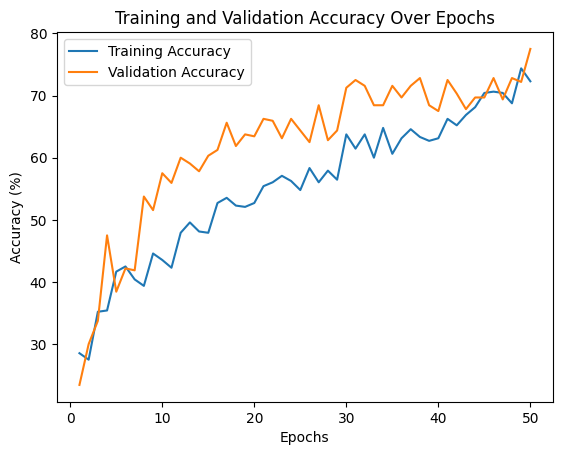

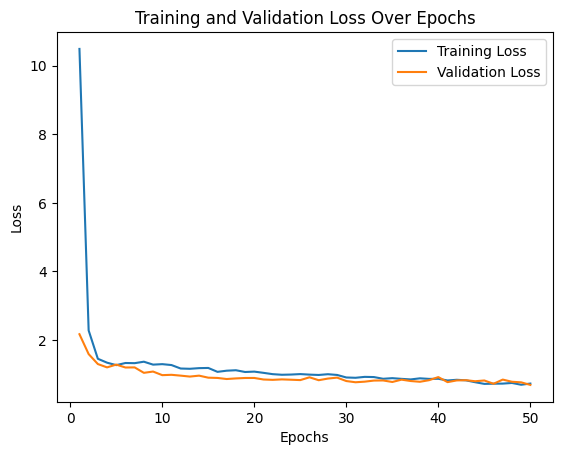

In [37]:
from tqdm import tqdm
import torch
import os

num_epochs = 50

best_accuracy = 0

best_model_path = "/kaggle/working/deep_finetune_best_model_1.pth"

train_acc = []
test_acc = []
epoches = []
train_loss = []
test_loss = []
prev_train_acc = prev_test_acc = prev_train_loss = prev_test_loss = None

# Training loop
for epoch in range(num_epochs):
    model_ft.train()
    running_loss = 0.0
    pbar = tqdm(test_dataloader_2, desc=f"Epoch {epoch+1}/{num_epochs}, Loss: 0.0000")

    pred_label = []
    true_label = []

    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)  
        optimizer.zero_grad() 
        outputs = model_ft(images) 
        
        _, predicted = torch.max(outputs.data, 1) 
        pred_label.extend(predicted.cpu().numpy())  
        true_label.extend(labels.cpu().numpy()) 

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()  

        running_loss += loss.item()  
        pbar.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(test_dataloader_2):.4f}") 

    # Calculate and print training accuracy
    train_correct = sum(p == t for p, t in zip(pred_label, true_label))
    train_accuracy = 100 * train_correct / len(true_label)
    train_acc.append(train_accuracy)
    epoches.append(epoch + 1)
    train_loss.append(running_loss/len(test_dataloader_2))

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(test_dataloader_2):.4f}, Training Accuracy: {train_accuracy:.2f}%')

    # Validation
    model_ft.eval() 
    correct = 0 
    total = 0 
    running_loss_test = 0
    with torch.no_grad(): 
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)  
            outputs = model_ft(images) 
            _, predicted = torch.max(outputs.data, 1) 
            total += labels.size(0) 
            correct += (predicted == labels).sum().item()  
            loss = criterion(outputs, labels)  
            running_loss_test += loss.item() 

    accuracy_test = 100 * correct / total
    test_acc.append(accuracy_test)
    test_loss.append(running_loss_test/len(test_dataloader))

    print(f'Validation Accuracy: {accuracy_test:.2f}%') 

    # Calculate convergence speed
    if prev_train_acc is not None:
        acc_conv_speed_train = train_accuracy - prev_train_acc
        acc_conv_speed_test = accuracy_test - prev_test_acc
        loss_conv_speed_train = prev_train_loss - train_loss[-1]
        loss_conv_speed_test = prev_test_loss - test_loss[-1]

        print(f'Convergence Speed - Training Accuracy: {acc_conv_speed_train:.4f}, Validation Accuracy: {acc_conv_speed_test:.4f}')
        print(f'Convergence Speed - Training Loss: {loss_conv_speed_train:.4f}, Validation Loss: {loss_conv_speed_test:.4f}')

    # Update previous epoch values
    prev_train_acc, prev_test_acc = train_accuracy, accuracy_test
    prev_train_loss, prev_test_loss = train_loss[-1], test_loss[-1]

    # Save best model if the validation accuracy improves
    if accuracy_test > best_accuracy:
        best_accuracy = accuracy_test
        os.makedirs( "/kaggle/working/", exist_ok=True)
        torch.save(model_ft.state_dict(), best_model_path)
        print(f"Best model saved with accuracy {best_accuracy:.2f}%")

import matplotlib.pyplot as plt

plt.plot(epoches, train_acc, label='Training Accuracy')
plt.plot(epoches, test_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

# Plot loss curves
plt.plot(epoches, train_loss, label='Training Loss')
plt.plot(epoches, test_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()


Epoch 1/50, Loss: 0.6767: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [1/50], Loss: 0.6767, Training Accuracy: 74.58%
Validation Accuracy: 79.06%
Best model saved with accuracy 79.06%


Epoch 2/50, Loss: 0.6929: 100%|██████████| 15/15 [00:15<00:00,  1.00s/it]


Epoch [2/50], Loss: 0.6929, Training Accuracy: 73.12%
Validation Accuracy: 72.19%
Convergence Speed - Training Accuracy: -1.4583, Validation Accuracy: -6.8750
Convergence Speed - Training Loss: -0.0162, Validation Loss: -0.0928


Epoch 3/50, Loss: 0.7640: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [3/50], Loss: 0.7640, Training Accuracy: 70.21%
Validation Accuracy: 74.38%
Convergence Speed - Training Accuracy: -2.9167, Validation Accuracy: 2.1875
Convergence Speed - Training Loss: -0.0711, Validation Loss: 0.0258


Epoch 4/50, Loss: 0.8282: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [4/50], Loss: 0.8282, Training Accuracy: 68.96%
Validation Accuracy: 69.38%
Convergence Speed - Training Accuracy: -1.2500, Validation Accuracy: -5.0000
Convergence Speed - Training Loss: -0.0642, Validation Loss: -0.1524


Epoch 5/50, Loss: 0.8488: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [5/50], Loss: 0.8488, Training Accuracy: 67.29%
Validation Accuracy: 64.38%
Convergence Speed - Training Accuracy: -1.6667, Validation Accuracy: -5.0000
Convergence Speed - Training Loss: -0.0205, Validation Loss: 0.0383


Epoch 6/50, Loss: 0.8096: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [6/50], Loss: 0.8096, Training Accuracy: 68.75%
Validation Accuracy: 68.44%
Convergence Speed - Training Accuracy: 1.4583, Validation Accuracy: 4.0625
Convergence Speed - Training Loss: 0.0392, Validation Loss: 0.1062


Epoch 7/50, Loss: 0.7176: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [7/50], Loss: 0.7176, Training Accuracy: 69.38%
Validation Accuracy: 70.31%
Convergence Speed - Training Accuracy: 0.6250, Validation Accuracy: 1.8750
Convergence Speed - Training Loss: 0.0920, Validation Loss: -0.0764


Epoch 8/50, Loss: 0.6761: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [8/50], Loss: 0.6761, Training Accuracy: 72.71%
Validation Accuracy: 72.81%
Convergence Speed - Training Accuracy: 3.3333, Validation Accuracy: 2.5000
Convergence Speed - Training Loss: 0.0414, Validation Loss: 0.0779


Epoch 9/50, Loss: 0.6302: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [9/50], Loss: 0.6302, Training Accuracy: 75.00%
Validation Accuracy: 75.31%
Convergence Speed - Training Accuracy: 2.2917, Validation Accuracy: 2.5000
Convergence Speed - Training Loss: 0.0459, Validation Loss: 0.0422


Epoch 10/50, Loss: 0.6471: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [10/50], Loss: 0.6471, Training Accuracy: 75.00%
Validation Accuracy: 74.38%
Convergence Speed - Training Accuracy: 0.0000, Validation Accuracy: -0.9375
Convergence Speed - Training Loss: -0.0169, Validation Loss: 0.0063


Epoch 11/50, Loss: 0.6439: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [11/50], Loss: 0.6439, Training Accuracy: 73.96%
Validation Accuracy: 76.56%
Convergence Speed - Training Accuracy: -1.0417, Validation Accuracy: 2.1875
Convergence Speed - Training Loss: 0.0032, Validation Loss: 0.0337


Epoch 12/50, Loss: 0.6189: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [12/50], Loss: 0.6189, Training Accuracy: 76.88%
Validation Accuracy: 72.81%
Convergence Speed - Training Accuracy: 2.9167, Validation Accuracy: -3.7500
Convergence Speed - Training Loss: 0.0250, Validation Loss: -0.0163


Epoch 13/50, Loss: 0.6301: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [13/50], Loss: 0.6301, Training Accuracy: 75.62%
Validation Accuracy: 74.06%
Convergence Speed - Training Accuracy: -1.2500, Validation Accuracy: 1.2500
Convergence Speed - Training Loss: -0.0111, Validation Loss: 0.0078


Epoch 14/50, Loss: 0.6154: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [14/50], Loss: 0.6154, Training Accuracy: 77.92%
Validation Accuracy: 74.06%
Convergence Speed - Training Accuracy: 2.2917, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0147, Validation Loss: -0.0128


Epoch 15/50, Loss: 0.6035: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [15/50], Loss: 0.6035, Training Accuracy: 78.12%
Validation Accuracy: 73.12%
Convergence Speed - Training Accuracy: 0.2083, Validation Accuracy: -0.9375
Convergence Speed - Training Loss: 0.0119, Validation Loss: 0.0131


Epoch 16/50, Loss: 0.6092: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [16/50], Loss: 0.6092, Training Accuracy: 76.88%
Validation Accuracy: 77.50%
Convergence Speed - Training Accuracy: -1.2500, Validation Accuracy: 4.3750
Convergence Speed - Training Loss: -0.0057, Validation Loss: 0.0394


Epoch 17/50, Loss: 0.5566: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [17/50], Loss: 0.5566, Training Accuracy: 78.54%
Validation Accuracy: 75.94%
Convergence Speed - Training Accuracy: 1.6667, Validation Accuracy: -1.5625
Convergence Speed - Training Loss: 0.0526, Validation Loss: -0.0484


Epoch 18/50, Loss: 0.6008: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [18/50], Loss: 0.6008, Training Accuracy: 77.29%
Validation Accuracy: 73.12%
Convergence Speed - Training Accuracy: -1.2500, Validation Accuracy: -2.8125
Convergence Speed - Training Loss: -0.0442, Validation Loss: -0.0317


Epoch 19/50, Loss: 0.5884: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [19/50], Loss: 0.5884, Training Accuracy: 75.42%
Validation Accuracy: 77.50%
Convergence Speed - Training Accuracy: -1.8750, Validation Accuracy: 4.3750
Convergence Speed - Training Loss: 0.0124, Validation Loss: 0.0647


Epoch 20/50, Loss: 0.5641: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [20/50], Loss: 0.5641, Training Accuracy: 78.75%
Validation Accuracy: 80.00%
Convergence Speed - Training Accuracy: 3.3333, Validation Accuracy: 2.5000
Convergence Speed - Training Loss: 0.0243, Validation Loss: 0.0851
Best model saved with accuracy 80.00%


Epoch 21/50, Loss: 0.5497: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [21/50], Loss: 0.5497, Training Accuracy: 80.00%
Validation Accuracy: 76.88%
Convergence Speed - Training Accuracy: 1.2500, Validation Accuracy: -3.1250
Convergence Speed - Training Loss: 0.0144, Validation Loss: -0.0593


Epoch 22/50, Loss: 0.5497: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [22/50], Loss: 0.5497, Training Accuracy: 80.42%
Validation Accuracy: 74.69%
Convergence Speed - Training Accuracy: 0.4167, Validation Accuracy: -2.1875
Convergence Speed - Training Loss: 0.0001, Validation Loss: -0.0431


Epoch 23/50, Loss: 0.6012: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [23/50], Loss: 0.6012, Training Accuracy: 76.46%
Validation Accuracy: 72.81%
Convergence Speed - Training Accuracy: -3.9583, Validation Accuracy: -1.8750
Convergence Speed - Training Loss: -0.0515, Validation Loss: 0.0161


Epoch 24/50, Loss: 0.5668: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [24/50], Loss: 0.5668, Training Accuracy: 78.12%
Validation Accuracy: 74.38%
Convergence Speed - Training Accuracy: 1.6667, Validation Accuracy: 1.5625
Convergence Speed - Training Loss: 0.0344, Validation Loss: 0.0271


Epoch 25/50, Loss: 0.5456: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [25/50], Loss: 0.5456, Training Accuracy: 77.71%
Validation Accuracy: 75.94%
Convergence Speed - Training Accuracy: -0.4167, Validation Accuracy: 1.5625
Convergence Speed - Training Loss: 0.0213, Validation Loss: 0.0236


Epoch 26/50, Loss: 0.5091: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [26/50], Loss: 0.5091, Training Accuracy: 82.08%
Validation Accuracy: 79.06%
Convergence Speed - Training Accuracy: 4.3750, Validation Accuracy: 3.1250
Convergence Speed - Training Loss: 0.0365, Validation Loss: 0.0484


Epoch 27/50, Loss: 0.5164: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [27/50], Loss: 0.5164, Training Accuracy: 78.96%
Validation Accuracy: 78.75%
Convergence Speed - Training Accuracy: -3.1250, Validation Accuracy: -0.3125
Convergence Speed - Training Loss: -0.0073, Validation Loss: -0.0637


Epoch 28/50, Loss: 0.4935: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [28/50], Loss: 0.4935, Training Accuracy: 83.12%
Validation Accuracy: 76.88%
Convergence Speed - Training Accuracy: 4.1667, Validation Accuracy: -1.8750
Convergence Speed - Training Loss: 0.0229, Validation Loss: -0.0672


Epoch 29/50, Loss: 0.5373: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [29/50], Loss: 0.5373, Training Accuracy: 78.96%
Validation Accuracy: 80.31%
Convergence Speed - Training Accuracy: -4.1667, Validation Accuracy: 3.4375
Convergence Speed - Training Loss: -0.0439, Validation Loss: 0.1378
Best model saved with accuracy 80.31%


Epoch 30/50, Loss: 0.4986: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [30/50], Loss: 0.4986, Training Accuracy: 81.25%
Validation Accuracy: 74.06%
Convergence Speed - Training Accuracy: 2.2917, Validation Accuracy: -6.2500
Convergence Speed - Training Loss: 0.0387, Validation Loss: -0.1152


Epoch 31/50, Loss: 0.5070: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [31/50], Loss: 0.5070, Training Accuracy: 81.04%
Validation Accuracy: 75.62%
Convergence Speed - Training Accuracy: -0.2083, Validation Accuracy: 1.5625
Convergence Speed - Training Loss: -0.0083, Validation Loss: 0.0093


Epoch 32/50, Loss: 0.5029: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [32/50], Loss: 0.5029, Training Accuracy: 81.67%
Validation Accuracy: 75.62%
Convergence Speed - Training Accuracy: 0.6250, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0041, Validation Loss: 0.0401


Epoch 33/50, Loss: 0.4980: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [33/50], Loss: 0.4980, Training Accuracy: 82.71%
Validation Accuracy: 80.31%
Convergence Speed - Training Accuracy: 1.0417, Validation Accuracy: 4.6875
Convergence Speed - Training Loss: 0.0049, Validation Loss: 0.0544


Epoch 34/50, Loss: 0.4833: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [34/50], Loss: 0.4833, Training Accuracy: 83.54%
Validation Accuracy: 78.44%
Convergence Speed - Training Accuracy: 0.8333, Validation Accuracy: -1.8750
Convergence Speed - Training Loss: 0.0147, Validation Loss: -0.0262


Epoch 35/50, Loss: 0.5231: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [35/50], Loss: 0.5231, Training Accuracy: 80.00%
Validation Accuracy: 77.81%
Convergence Speed - Training Accuracy: -3.5417, Validation Accuracy: -0.6250
Convergence Speed - Training Loss: -0.0398, Validation Loss: -0.0029


Epoch 36/50, Loss: 0.4612: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [36/50], Loss: 0.4612, Training Accuracy: 81.46%
Validation Accuracy: 75.31%
Convergence Speed - Training Accuracy: 1.4583, Validation Accuracy: -2.5000
Convergence Speed - Training Loss: 0.0619, Validation Loss: -0.0662


Epoch 37/50, Loss: 0.4858: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [37/50], Loss: 0.4858, Training Accuracy: 80.00%
Validation Accuracy: 79.38%
Convergence Speed - Training Accuracy: -1.4583, Validation Accuracy: 4.0625
Convergence Speed - Training Loss: -0.0246, Validation Loss: 0.0839


Epoch 38/50, Loss: 0.4511: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [38/50], Loss: 0.4511, Training Accuracy: 82.50%
Validation Accuracy: 75.00%
Convergence Speed - Training Accuracy: 2.5000, Validation Accuracy: -4.3750
Convergence Speed - Training Loss: 0.0347, Validation Loss: -0.1369


Epoch 39/50, Loss: 0.4672: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [39/50], Loss: 0.4672, Training Accuracy: 79.79%
Validation Accuracy: 75.62%
Convergence Speed - Training Accuracy: -2.7083, Validation Accuracy: 0.6250
Convergence Speed - Training Loss: -0.0161, Validation Loss: 0.0098


Epoch 40/50, Loss: 0.4727: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [40/50], Loss: 0.4727, Training Accuracy: 81.25%
Validation Accuracy: 78.75%
Convergence Speed - Training Accuracy: 1.4583, Validation Accuracy: 3.1250
Convergence Speed - Training Loss: -0.0055, Validation Loss: 0.1501


Epoch 41/50, Loss: 0.4422: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [41/50], Loss: 0.4422, Training Accuracy: 83.75%
Validation Accuracy: 74.69%
Convergence Speed - Training Accuracy: 2.5000, Validation Accuracy: -4.0625
Convergence Speed - Training Loss: 0.0305, Validation Loss: -0.1509


Epoch 42/50, Loss: 0.4334: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [42/50], Loss: 0.4334, Training Accuracy: 83.54%
Validation Accuracy: 75.94%
Convergence Speed - Training Accuracy: -0.2083, Validation Accuracy: 1.2500
Convergence Speed - Training Loss: 0.0088, Validation Loss: 0.0783


Epoch 43/50, Loss: 0.4157: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [43/50], Loss: 0.4157, Training Accuracy: 85.00%
Validation Accuracy: 73.75%
Convergence Speed - Training Accuracy: 1.4583, Validation Accuracy: -2.1875
Convergence Speed - Training Loss: 0.0177, Validation Loss: -0.0834


Epoch 44/50, Loss: 0.4362: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [44/50], Loss: 0.4362, Training Accuracy: 83.54%
Validation Accuracy: 77.50%
Convergence Speed - Training Accuracy: -1.4583, Validation Accuracy: 3.7500
Convergence Speed - Training Loss: -0.0206, Validation Loss: 0.0991


Epoch 45/50, Loss: 0.4263: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [45/50], Loss: 0.4263, Training Accuracy: 83.75%
Validation Accuracy: 75.31%
Convergence Speed - Training Accuracy: 0.2083, Validation Accuracy: -2.1875
Convergence Speed - Training Loss: 0.0100, Validation Loss: -0.0453


Epoch 46/50, Loss: 0.4447: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [46/50], Loss: 0.4447, Training Accuracy: 83.54%
Validation Accuracy: 80.00%
Convergence Speed - Training Accuracy: -0.2083, Validation Accuracy: 4.6875
Convergence Speed - Training Loss: -0.0185, Validation Loss: 0.1339


Epoch 47/50, Loss: 0.4324: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [47/50], Loss: 0.4324, Training Accuracy: 84.58%
Validation Accuracy: 77.19%
Convergence Speed - Training Accuracy: 1.0417, Validation Accuracy: -2.8125
Convergence Speed - Training Loss: 0.0123, Validation Loss: -0.0330


Epoch 48/50, Loss: 0.5008: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [48/50], Loss: 0.5008, Training Accuracy: 81.46%
Validation Accuracy: 75.94%
Convergence Speed - Training Accuracy: -3.1250, Validation Accuracy: -1.2500
Convergence Speed - Training Loss: -0.0683, Validation Loss: -0.1143


Epoch 49/50, Loss: 0.4735: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [49/50], Loss: 0.4735, Training Accuracy: 81.46%
Validation Accuracy: 80.00%
Convergence Speed - Training Accuracy: 0.0000, Validation Accuracy: 4.0625
Convergence Speed - Training Loss: 0.0273, Validation Loss: 0.1691


Epoch 50/50, Loss: 0.4182: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [50/50], Loss: 0.4182, Training Accuracy: 85.42%
Validation Accuracy: 80.62%
Convergence Speed - Training Accuracy: 3.9583, Validation Accuracy: 0.6250
Convergence Speed - Training Loss: 0.0553, Validation Loss: -0.0107
Best model saved with accuracy 80.62%


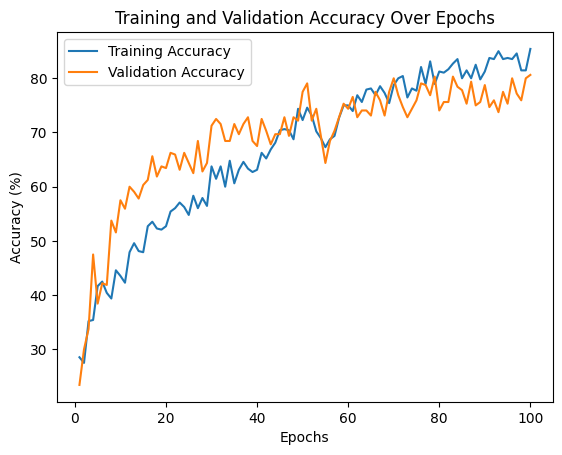

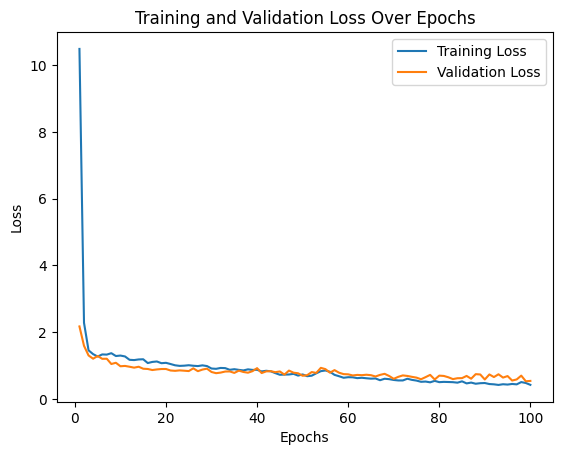

In [38]:
from tqdm import tqdm
import torch
import os

num_epochs = 50

best_model_path = "/kaggle/working/deep_finetune_best_model_2.pth"


prev_train_acc = prev_test_acc = prev_train_loss = prev_test_loss = None

# Training loop
for epoch in range(num_epochs):
    model_ft.train()
    running_loss = 0.0
    pbar = tqdm(test_dataloader_2, desc=f"Epoch {epoch+1}/{num_epochs}, Loss: 0.0000")

    pred_label = []
    true_label = []

    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)  
        optimizer.zero_grad() 
        outputs = model_ft(images) 
        
        _, predicted = torch.max(outputs.data, 1) 
        pred_label.extend(predicted.cpu().numpy())  
        true_label.extend(labels.cpu().numpy()) 

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()  

        running_loss += loss.item()  
        pbar.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(test_dataloader_2):.4f}") 

    # Calculate and print training accuracy
    train_correct = sum(p == t for p, t in zip(pred_label, true_label))
    train_accuracy = 100 * train_correct / len(true_label)
    train_acc.append(train_accuracy)
    epoches.append(epoch + 51)
    train_loss.append(running_loss/len(test_dataloader_2))

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(test_dataloader_2):.4f}, Training Accuracy: {train_accuracy:.2f}%')

    # Validation
    model_ft.eval() 
    correct = 0 
    total = 0 
    running_loss_test = 0
    with torch.no_grad(): 
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)  
            outputs = model_ft(images) 
            _, predicted = torch.max(outputs.data, 1) 
            total += labels.size(0) 
            correct += (predicted == labels).sum().item()  
            loss = criterion(outputs, labels)  
            running_loss_test += loss.item() 

    accuracy_test = 100 * correct / total
    test_acc.append(accuracy_test)
    test_loss.append(running_loss_test/len(test_dataloader))

    print(f'Validation Accuracy: {accuracy_test:.2f}%') 

    # Calculate convergence speed
    if prev_train_acc is not None:
        acc_conv_speed_train = train_accuracy - prev_train_acc
        acc_conv_speed_test = accuracy_test - prev_test_acc
        loss_conv_speed_train = prev_train_loss - train_loss[-1]
        loss_conv_speed_test = prev_test_loss - test_loss[-1]

        print(f'Convergence Speed - Training Accuracy: {acc_conv_speed_train:.4f}, Validation Accuracy: {acc_conv_speed_test:.4f}')
        print(f'Convergence Speed - Training Loss: {loss_conv_speed_train:.4f}, Validation Loss: {loss_conv_speed_test:.4f}')

    # Update previous epoch values
    prev_train_acc, prev_test_acc = train_accuracy, accuracy_test
    prev_train_loss, prev_test_loss = train_loss[-1], test_loss[-1]

    # Save best model if the validation accuracy improves
    if accuracy_test > best_accuracy:
        best_accuracy = accuracy_test
        os.makedirs( "/kaggle/working/", exist_ok=True)
        torch.save(model_ft.state_dict(), best_model_path)
        print(f"Best model saved with accuracy {best_accuracy:.2f}%")

import matplotlib.pyplot as plt

plt.plot(epoches, train_acc, label='Training Accuracy')
plt.plot(epoches, test_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

# Plot loss curves
plt.plot(epoches, train_loss, label='Training Loss')
plt.plot(epoches, test_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()


In [41]:
optimizer = torch.optim.Adam(model_ft.parameters(), lr=1e-3)

In [39]:
from tqdm import tqdm
import torch
import os

num_epochs = 50

best_model_path = "/kaggle/working/deep_finetune_best_model_2.pth"


prev_train_acc = prev_test_acc = prev_train_loss = prev_test_loss = None

# Training loop
for epoch in range(num_epochs):
    model_ft.train()
    running_loss = 0.0
    pbar = tqdm(test_dataloader_2, desc=f"Epoch {epoch+1}/{num_epochs}, Loss: 0.0000")

    pred_label = []
    true_label = []

    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)  
        optimizer.zero_grad() 
        outputs = model_ft(images) 
        
        _, predicted = torch.max(outputs.data, 1) 
        pred_label.extend(predicted.cpu().numpy())  
        true_label.extend(labels.cpu().numpy()) 

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()  

        running_loss += loss.item()  
        pbar.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(test_dataloader_2):.4f}") 

    # Calculate and print training accuracy
    train_correct = sum(p == t for p, t in zip(pred_label, true_label))
    train_accuracy = 100 * train_correct / len(true_label)
    train_acc.append(train_accuracy)
    epoches.append(epoch + 101)
    train_loss.append(running_loss/len(test_dataloader_2))

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(test_dataloader_2):.4f}, Training Accuracy: {train_accuracy:.2f}%')

    # Validation
    model_ft.eval() 
    correct = 0 
    total = 0 
    running_loss_test = 0
    with torch.no_grad(): 
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)  
            outputs = model_ft(images) 
            _, predicted = torch.max(outputs.data, 1) 
            total += labels.size(0) 
            correct += (predicted == labels).sum().item()  
            loss = criterion(outputs, labels)  
            running_loss_test += loss.item() 

    accuracy_test = 100 * correct / total
    test_acc.append(accuracy_test)
    test_loss.append(running_loss_test/len(test_dataloader))

    print(f'Validation Accuracy: {accuracy_test:.2f}%') 

    # Calculate convergence speed
    if prev_train_acc is not None:
        acc_conv_speed_train = train_accuracy - prev_train_acc
        acc_conv_speed_test = accuracy_test - prev_test_acc
        loss_conv_speed_train = prev_train_loss - train_loss[-1]
        loss_conv_speed_test = prev_test_loss - test_loss[-1]

        print(f'Convergence Speed - Training Accuracy: {acc_conv_speed_train:.4f}, Validation Accuracy: {acc_conv_speed_test:.4f}')
        print(f'Convergence Speed - Training Loss: {loss_conv_speed_train:.4f}, Validation Loss: {loss_conv_speed_test:.4f}')

    # Update previous epoch values
    prev_train_acc, prev_test_acc = train_accuracy, accuracy_test
    prev_train_loss, prev_test_loss = train_loss[-1], test_loss[-1]

    # Save best model if the validation accuracy improves
    if accuracy_test > best_accuracy:
        best_accuracy = accuracy_test
        os.makedirs( "/kaggle/working/", exist_ok=True)
        torch.save(model_ft.state_dict(), best_model_path)
        print(f"Best model saved with accuracy {best_accuracy:.2f}%")

import matplotlib.pyplot as plt

plt.plot(epoches, train_acc, label='Training Accuracy')
plt.plot(epoches, test_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

# Plot loss curves
plt.plot(epoches, train_loss, label='Training Loss')
plt.plot(epoches, test_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()


Epoch 1/50, Loss: 0.3514: 100%|██████████| 15/15 [00:15<00:00,  1.01s/it]


Epoch [1/50], Loss: 0.3514, Training Accuracy: 86.88%
Validation Accuracy: 78.12%


Epoch 2/50, Loss: 0.3672: 100%|██████████| 15/15 [00:15<00:00,  1.00s/it]


Epoch [2/50], Loss: 0.3672, Training Accuracy: 87.08%
Validation Accuracy: 78.75%
Convergence Speed - Training Accuracy: 0.2083, Validation Accuracy: 0.6250
Convergence Speed - Training Loss: -0.0158, Validation Loss: 0.0169


Epoch 3/50, Loss: 0.3644: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


Epoch [3/50], Loss: 0.3644, Training Accuracy: 87.29%
Validation Accuracy: 78.44%
Convergence Speed - Training Accuracy: 0.2083, Validation Accuracy: -0.3125
Convergence Speed - Training Loss: 0.0028, Validation Loss: -0.0675


Epoch 4/50, Loss: 0.3409: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


Epoch [4/50], Loss: 0.3409, Training Accuracy: 86.88%
Validation Accuracy: 77.50%
Convergence Speed - Training Accuracy: -0.4167, Validation Accuracy: -0.9375
Convergence Speed - Training Loss: 0.0235, Validation Loss: 0.0079


Epoch 5/50, Loss: 0.3306: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [5/50], Loss: 0.3306, Training Accuracy: 88.54%
Validation Accuracy: 78.75%
Convergence Speed - Training Accuracy: 1.6667, Validation Accuracy: 1.2500
Convergence Speed - Training Loss: 0.0103, Validation Loss: -0.0167


Epoch 6/50, Loss: 0.3347: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [6/50], Loss: 0.3347, Training Accuracy: 89.58%
Validation Accuracy: 77.50%
Convergence Speed - Training Accuracy: 1.0417, Validation Accuracy: -1.2500
Convergence Speed - Training Loss: -0.0041, Validation Loss: -0.0157


Epoch 7/50, Loss: 0.3693: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [7/50], Loss: 0.3693, Training Accuracy: 88.75%
Validation Accuracy: 78.75%
Convergence Speed - Training Accuracy: -0.8333, Validation Accuracy: 1.2500
Convergence Speed - Training Loss: -0.0346, Validation Loss: 0.0043


Epoch 8/50, Loss: 0.3552: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [8/50], Loss: 0.3552, Training Accuracy: 88.12%
Validation Accuracy: 78.75%
Convergence Speed - Training Accuracy: -0.6250, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0141, Validation Loss: 0.0831


Epoch 9/50, Loss: 0.3085: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [9/50], Loss: 0.3085, Training Accuracy: 90.42%
Validation Accuracy: 77.50%
Convergence Speed - Training Accuracy: 2.2917, Validation Accuracy: -1.2500
Convergence Speed - Training Loss: 0.0467, Validation Loss: -0.1422


Epoch 10/50, Loss: 0.3524: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [10/50], Loss: 0.3524, Training Accuracy: 86.25%
Validation Accuracy: 76.88%
Convergence Speed - Training Accuracy: -4.1667, Validation Accuracy: -0.6250
Convergence Speed - Training Loss: -0.0439, Validation Loss: -0.0046


Epoch 11/50, Loss: 0.4267: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [11/50], Loss: 0.4267, Training Accuracy: 82.29%
Validation Accuracy: 78.44%
Convergence Speed - Training Accuracy: -3.9583, Validation Accuracy: 1.5625
Convergence Speed - Training Loss: -0.0743, Validation Loss: 0.1261


Epoch 12/50, Loss: 0.3568: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [12/50], Loss: 0.3568, Training Accuracy: 87.92%
Validation Accuracy: 80.31%
Convergence Speed - Training Accuracy: 5.6250, Validation Accuracy: 1.8750
Convergence Speed - Training Loss: 0.0699, Validation Loss: -0.0262


Epoch 13/50, Loss: 0.3599: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [13/50], Loss: 0.3599, Training Accuracy: 85.83%
Validation Accuracy: 80.00%
Convergence Speed - Training Accuracy: -2.0833, Validation Accuracy: -0.3125
Convergence Speed - Training Loss: -0.0031, Validation Loss: 0.0271


Epoch 14/50, Loss: 0.3316: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [14/50], Loss: 0.3316, Training Accuracy: 87.92%
Validation Accuracy: 79.69%
Convergence Speed - Training Accuracy: 2.0833, Validation Accuracy: -0.3125
Convergence Speed - Training Loss: 0.0284, Validation Loss: -0.0024


Epoch 15/50, Loss: 0.3313: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [15/50], Loss: 0.3313, Training Accuracy: 88.33%
Validation Accuracy: 79.38%
Convergence Speed - Training Accuracy: 0.4167, Validation Accuracy: -0.3125
Convergence Speed - Training Loss: 0.0003, Validation Loss: -0.0396


Epoch 16/50, Loss: 0.3721: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [16/50], Loss: 0.3721, Training Accuracy: 86.25%
Validation Accuracy: 77.50%
Convergence Speed - Training Accuracy: -2.0833, Validation Accuracy: -1.8750
Convergence Speed - Training Loss: -0.0408, Validation Loss: -0.0218


Epoch 17/50, Loss: 0.4000: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [17/50], Loss: 0.4000, Training Accuracy: 85.21%
Validation Accuracy: 79.38%
Convergence Speed - Training Accuracy: -1.0417, Validation Accuracy: 1.8750
Convergence Speed - Training Loss: -0.0280, Validation Loss: 0.0831


Epoch 18/50, Loss: 0.3278: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [18/50], Loss: 0.3278, Training Accuracy: 88.54%
Validation Accuracy: 78.44%
Convergence Speed - Training Accuracy: 3.3333, Validation Accuracy: -0.9375
Convergence Speed - Training Loss: 0.0723, Validation Loss: -0.1231


Epoch 19/50, Loss: 0.4671: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [19/50], Loss: 0.4671, Training Accuracy: 82.92%
Validation Accuracy: 79.69%
Convergence Speed - Training Accuracy: -5.6250, Validation Accuracy: 1.2500
Convergence Speed - Training Loss: -0.1394, Validation Loss: 0.0251


Epoch 20/50, Loss: 0.3311: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [20/50], Loss: 0.3311, Training Accuracy: 86.88%
Validation Accuracy: 81.25%
Convergence Speed - Training Accuracy: 3.9583, Validation Accuracy: 1.5625
Convergence Speed - Training Loss: 0.1361, Validation Loss: 0.0782
Best model saved with accuracy 81.25%


Epoch 21/50, Loss: 0.3118: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [21/50], Loss: 0.3118, Training Accuracy: 89.79%
Validation Accuracy: 83.12%
Convergence Speed - Training Accuracy: 2.9167, Validation Accuracy: 1.8750
Convergence Speed - Training Loss: 0.0192, Validation Loss: 0.0854
Best model saved with accuracy 83.12%


Epoch 22/50, Loss: 0.2928: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [22/50], Loss: 0.2928, Training Accuracy: 90.00%
Validation Accuracy: 83.12%
Convergence Speed - Training Accuracy: 0.2083, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0190, Validation Loss: -0.0349


Epoch 23/50, Loss: 0.2466: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [23/50], Loss: 0.2466, Training Accuracy: 92.29%
Validation Accuracy: 82.19%
Convergence Speed - Training Accuracy: 2.2917, Validation Accuracy: -0.9375
Convergence Speed - Training Loss: 0.0462, Validation Loss: 0.0158


Epoch 24/50, Loss: 0.3401: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [24/50], Loss: 0.3401, Training Accuracy: 87.71%
Validation Accuracy: 81.88%
Convergence Speed - Training Accuracy: -4.5833, Validation Accuracy: -0.3125
Convergence Speed - Training Loss: -0.0936, Validation Loss: -0.0209


Epoch 25/50, Loss: 0.2796: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [25/50], Loss: 0.2796, Training Accuracy: 91.04%
Validation Accuracy: 82.50%
Convergence Speed - Training Accuracy: 3.3333, Validation Accuracy: 0.6250
Convergence Speed - Training Loss: 0.0606, Validation Loss: -0.0579


Epoch 26/50, Loss: 0.2438: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [26/50], Loss: 0.2438, Training Accuracy: 91.67%
Validation Accuracy: 81.88%
Convergence Speed - Training Accuracy: 0.6250, Validation Accuracy: -0.6250
Convergence Speed - Training Loss: 0.0357, Validation Loss: 0.0245


Epoch 27/50, Loss: 0.3311: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [27/50], Loss: 0.3311, Training Accuracy: 87.92%
Validation Accuracy: 79.06%
Convergence Speed - Training Accuracy: -3.7500, Validation Accuracy: -2.8125
Convergence Speed - Training Loss: -0.0873, Validation Loss: -0.0103


Epoch 28/50, Loss: 0.3132: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [28/50], Loss: 0.3132, Training Accuracy: 88.33%
Validation Accuracy: 76.25%
Convergence Speed - Training Accuracy: 0.4167, Validation Accuracy: -2.8125
Convergence Speed - Training Loss: 0.0179, Validation Loss: -0.0369


Epoch 29/50, Loss: 0.3670: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [29/50], Loss: 0.3670, Training Accuracy: 86.67%
Validation Accuracy: 80.31%
Convergence Speed - Training Accuracy: -1.6667, Validation Accuracy: 4.0625
Convergence Speed - Training Loss: -0.0538, Validation Loss: 0.0387


Epoch 30/50, Loss: 0.2675: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [30/50], Loss: 0.2675, Training Accuracy: 89.58%
Validation Accuracy: 82.19%
Convergence Speed - Training Accuracy: 2.9167, Validation Accuracy: 1.8750
Convergence Speed - Training Loss: 0.0995, Validation Loss: 0.0622


Epoch 31/50, Loss: 0.2124: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [31/50], Loss: 0.2124, Training Accuracy: 93.12%
Validation Accuracy: 83.75%
Convergence Speed - Training Accuracy: 3.5417, Validation Accuracy: 1.5625
Convergence Speed - Training Loss: 0.0551, Validation Loss: -0.0101
Best model saved with accuracy 83.75%


Epoch 32/50, Loss: 0.1788: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [32/50], Loss: 0.1788, Training Accuracy: 92.92%
Validation Accuracy: 83.44%
Convergence Speed - Training Accuracy: -0.2083, Validation Accuracy: -0.3125
Convergence Speed - Training Loss: 0.0336, Validation Loss: -0.0257


Epoch 33/50, Loss: 0.2275: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [33/50], Loss: 0.2275, Training Accuracy: 92.92%
Validation Accuracy: 80.00%
Convergence Speed - Training Accuracy: 0.0000, Validation Accuracy: -3.4375
Convergence Speed - Training Loss: -0.0487, Validation Loss: -0.0368


Epoch 34/50, Loss: 0.1932: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [34/50], Loss: 0.1932, Training Accuracy: 93.12%
Validation Accuracy: 81.25%
Convergence Speed - Training Accuracy: 0.2083, Validation Accuracy: 1.2500
Convergence Speed - Training Loss: 0.0343, Validation Loss: -0.0523


Epoch 35/50, Loss: 0.1988: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [35/50], Loss: 0.1988, Training Accuracy: 94.17%
Validation Accuracy: 82.81%
Convergence Speed - Training Accuracy: 1.0417, Validation Accuracy: 1.5625
Convergence Speed - Training Loss: -0.0056, Validation Loss: 0.1090


Epoch 36/50, Loss: 0.0300:  27%|██▋       | 4/15 [00:04<00:13,  1.24s/it]


KeyboardInterrupt: 

In [ ]:
optimizer = torch.optim.Adam(model_ft.parameters(), lr=1e-3)

Epoch 1/50, Loss: 0.1881: 100%|██████████| 15/15 [00:15<00:00,  1.01s/it]


Epoch [1/50], Loss: 0.1881, Training Accuracy: 93.33%
Validation Accuracy: 82.19%


Epoch 2/50, Loss: 0.2049: 100%|██████████| 15/15 [00:15<00:00,  1.00s/it]


Epoch [2/50], Loss: 0.2049, Training Accuracy: 92.50%
Validation Accuracy: 77.50%
Convergence Speed - Training Accuracy: -0.8333, Validation Accuracy: -4.6875
Convergence Speed - Training Loss: -0.0168, Validation Loss: -0.1381


Epoch 3/50, Loss: 0.1845: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [3/50], Loss: 0.1845, Training Accuracy: 93.54%
Validation Accuracy: 82.81%
Convergence Speed - Training Accuracy: 1.0417, Validation Accuracy: 5.3125
Convergence Speed - Training Loss: 0.0205, Validation Loss: 0.1994


Epoch 4/50, Loss: 0.1506: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [4/50], Loss: 0.1506, Training Accuracy: 94.58%
Validation Accuracy: 82.19%
Convergence Speed - Training Accuracy: 1.0417, Validation Accuracy: -0.6250
Convergence Speed - Training Loss: 0.0338, Validation Loss: 0.0030


Epoch 5/50, Loss: 0.1193: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [5/50], Loss: 0.1193, Training Accuracy: 96.25%
Validation Accuracy: 82.81%
Convergence Speed - Training Accuracy: 1.6667, Validation Accuracy: 0.6250
Convergence Speed - Training Loss: 0.0313, Validation Loss: -0.0402


Epoch 6/50, Loss: 0.1327: 100%|██████████| 15/15 [00:14<00:00,  1.00it/s]


Epoch [6/50], Loss: 0.1327, Training Accuracy: 94.79%
Validation Accuracy: 83.44%
Convergence Speed - Training Accuracy: -1.4583, Validation Accuracy: 0.6250
Convergence Speed - Training Loss: -0.0134, Validation Loss: 0.0145


Epoch 7/50, Loss: 0.1255: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [7/50], Loss: 0.1255, Training Accuracy: 95.62%
Validation Accuracy: 83.12%
Convergence Speed - Training Accuracy: 0.8333, Validation Accuracy: -0.3125
Convergence Speed - Training Loss: 0.0072, Validation Loss: 0.0090


Epoch 8/50, Loss: 0.1294: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [8/50], Loss: 0.1294, Training Accuracy: 95.42%
Validation Accuracy: 81.56%
Convergence Speed - Training Accuracy: -0.2083, Validation Accuracy: -1.5625
Convergence Speed - Training Loss: -0.0039, Validation Loss: -0.0831


Epoch 9/50, Loss: 0.1207: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [9/50], Loss: 0.1207, Training Accuracy: 95.83%
Validation Accuracy: 81.56%
Convergence Speed - Training Accuracy: 0.4167, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0087, Validation Loss: 0.0152


Epoch 10/50, Loss: 0.1247: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [10/50], Loss: 0.1247, Training Accuracy: 95.62%
Validation Accuracy: 82.81%
Convergence Speed - Training Accuracy: -0.2083, Validation Accuracy: 1.2500
Convergence Speed - Training Loss: -0.0040, Validation Loss: 0.0090


Epoch 11/50, Loss: 0.0958: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [11/50], Loss: 0.0958, Training Accuracy: 97.08%
Validation Accuracy: 82.81%
Convergence Speed - Training Accuracy: 1.4583, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0289, Validation Loss: -0.0327


Epoch 12/50, Loss: 0.1148: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [12/50], Loss: 0.1148, Training Accuracy: 97.08%
Validation Accuracy: 82.81%
Convergence Speed - Training Accuracy: 0.0000, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: -0.0190, Validation Loss: 0.0034


Epoch 13/50, Loss: 0.1358: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [13/50], Loss: 0.1358, Training Accuracy: 95.00%
Validation Accuracy: 82.50%
Convergence Speed - Training Accuracy: -2.0833, Validation Accuracy: -0.3125
Convergence Speed - Training Loss: -0.0210, Validation Loss: 0.0636


Epoch 14/50, Loss: 0.1182: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [14/50], Loss: 0.1182, Training Accuracy: 95.83%
Validation Accuracy: 83.44%
Convergence Speed - Training Accuracy: 0.8333, Validation Accuracy: 0.9375
Convergence Speed - Training Loss: 0.0176, Validation Loss: 0.0020


Epoch 15/50, Loss: 0.1063: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [15/50], Loss: 0.1063, Training Accuracy: 96.88%
Validation Accuracy: 81.88%
Convergence Speed - Training Accuracy: 1.0417, Validation Accuracy: -1.5625
Convergence Speed - Training Loss: 0.0119, Validation Loss: 0.0454


Epoch 16/50, Loss: 0.0988: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [16/50], Loss: 0.0988, Training Accuracy: 97.08%
Validation Accuracy: 82.81%
Convergence Speed - Training Accuracy: 0.2083, Validation Accuracy: 0.9375
Convergence Speed - Training Loss: 0.0075, Validation Loss: -0.0722


Epoch 17/50, Loss: 0.1015: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [17/50], Loss: 0.1015, Training Accuracy: 96.67%
Validation Accuracy: 82.50%
Convergence Speed - Training Accuracy: -0.4167, Validation Accuracy: -0.3125
Convergence Speed - Training Loss: -0.0026, Validation Loss: -0.0882


Epoch 18/50, Loss: 0.0999: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [18/50], Loss: 0.0999, Training Accuracy: 96.88%
Validation Accuracy: 82.19%
Convergence Speed - Training Accuracy: 0.2083, Validation Accuracy: -0.3125
Convergence Speed - Training Loss: 0.0016, Validation Loss: 0.0569


Epoch 19/50, Loss: 0.0992: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [19/50], Loss: 0.0992, Training Accuracy: 97.71%
Validation Accuracy: 83.12%
Convergence Speed - Training Accuracy: 0.8333, Validation Accuracy: 0.9375
Convergence Speed - Training Loss: 0.0007, Validation Loss: 0.0733


Epoch 20/50, Loss: 0.1177: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [20/50], Loss: 0.1177, Training Accuracy: 96.25%
Validation Accuracy: 81.25%
Convergence Speed - Training Accuracy: -1.4583, Validation Accuracy: -1.8750
Convergence Speed - Training Loss: -0.0185, Validation Loss: -0.0739


Epoch 21/50, Loss: 0.0892: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [21/50], Loss: 0.0892, Training Accuracy: 96.88%
Validation Accuracy: 80.94%
Convergence Speed - Training Accuracy: 0.6250, Validation Accuracy: -0.3125
Convergence Speed - Training Loss: 0.0285, Validation Loss: 0.0746


Epoch 22/50, Loss: 0.0836: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [22/50], Loss: 0.0836, Training Accuracy: 97.71%
Validation Accuracy: 82.19%
Convergence Speed - Training Accuracy: 0.8333, Validation Accuracy: 1.2500
Convergence Speed - Training Loss: 0.0055, Validation Loss: -0.0339


Epoch 23/50, Loss: 0.0992: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [23/50], Loss: 0.0992, Training Accuracy: 96.67%
Validation Accuracy: 80.62%
Convergence Speed - Training Accuracy: -1.0417, Validation Accuracy: -1.5625
Convergence Speed - Training Loss: -0.0155, Validation Loss: 0.0166


Epoch 24/50, Loss: 0.0855: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [24/50], Loss: 0.0855, Training Accuracy: 96.88%
Validation Accuracy: 82.19%
Convergence Speed - Training Accuracy: 0.2083, Validation Accuracy: 1.5625
Convergence Speed - Training Loss: 0.0137, Validation Loss: -0.0383


Epoch 25/50, Loss: 0.0810: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [25/50], Loss: 0.0810, Training Accuracy: 98.12%
Validation Accuracy: 81.88%
Convergence Speed - Training Accuracy: 1.2500, Validation Accuracy: -0.3125
Convergence Speed - Training Loss: 0.0044, Validation Loss: -0.0230


Epoch 26/50, Loss: 0.0717: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [26/50], Loss: 0.0717, Training Accuracy: 98.12%
Validation Accuracy: 82.81%
Convergence Speed - Training Accuracy: 0.0000, Validation Accuracy: 0.9375
Convergence Speed - Training Loss: 0.0093, Validation Loss: 0.0773


Epoch 27/50, Loss: 0.0733: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [27/50], Loss: 0.0733, Training Accuracy: 98.54%
Validation Accuracy: 82.81%
Convergence Speed - Training Accuracy: 0.4167, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: -0.0016, Validation Loss: 0.0060


Epoch 28/50, Loss: 0.0703: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [28/50], Loss: 0.0703, Training Accuracy: 97.92%
Validation Accuracy: 81.88%
Convergence Speed - Training Accuracy: -0.6250, Validation Accuracy: -0.9375
Convergence Speed - Training Loss: 0.0030, Validation Loss: -0.0323


Epoch 29/50, Loss: 0.0604: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [29/50], Loss: 0.0604, Training Accuracy: 99.17%
Validation Accuracy: 80.94%
Convergence Speed - Training Accuracy: 1.2500, Validation Accuracy: -0.9375
Convergence Speed - Training Loss: 0.0099, Validation Loss: -0.0749


Epoch 30/50, Loss: 0.0656: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [30/50], Loss: 0.0656, Training Accuracy: 98.54%
Validation Accuracy: 81.88%
Convergence Speed - Training Accuracy: -0.6250, Validation Accuracy: 0.9375
Convergence Speed - Training Loss: -0.0052, Validation Loss: -0.0042


Epoch 31/50, Loss: 0.0688: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [31/50], Loss: 0.0688, Training Accuracy: 98.12%
Validation Accuracy: 82.50%
Convergence Speed - Training Accuracy: -0.4167, Validation Accuracy: 0.6250
Convergence Speed - Training Loss: -0.0033, Validation Loss: 0.0417


Epoch 32/50, Loss: 0.0637: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [32/50], Loss: 0.0637, Training Accuracy: 99.38%
Validation Accuracy: 81.56%
Convergence Speed - Training Accuracy: 1.2500, Validation Accuracy: -0.9375
Convergence Speed - Training Loss: 0.0051, Validation Loss: 0.0685


Epoch 33/50, Loss: 0.0522: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [33/50], Loss: 0.0522, Training Accuracy: 99.58%
Validation Accuracy: 84.38%
Convergence Speed - Training Accuracy: 0.2083, Validation Accuracy: 2.8125
Convergence Speed - Training Loss: 0.0115, Validation Loss: -0.0574
Best model saved with accuracy 84.38%


Epoch 34/50, Loss: 0.0587: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [34/50], Loss: 0.0587, Training Accuracy: 98.75%
Validation Accuracy: 83.44%
Convergence Speed - Training Accuracy: -0.8333, Validation Accuracy: -0.9375
Convergence Speed - Training Loss: -0.0064, Validation Loss: -0.0099


Epoch 35/50, Loss: 0.0601: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [35/50], Loss: 0.0601, Training Accuracy: 98.75%
Validation Accuracy: 84.69%
Convergence Speed - Training Accuracy: 0.0000, Validation Accuracy: 1.2500
Convergence Speed - Training Loss: -0.0014, Validation Loss: 0.0046
Best model saved with accuracy 84.69%


Epoch 36/50, Loss: 0.0586: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [36/50], Loss: 0.0586, Training Accuracy: 98.12%
Validation Accuracy: 83.44%
Convergence Speed - Training Accuracy: -0.6250, Validation Accuracy: -1.2500
Convergence Speed - Training Loss: 0.0014, Validation Loss: -0.0173


Epoch 37/50, Loss: 0.0757: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [37/50], Loss: 0.0757, Training Accuracy: 97.29%
Validation Accuracy: 83.12%
Convergence Speed - Training Accuracy: -0.8333, Validation Accuracy: -0.3125
Convergence Speed - Training Loss: -0.0171, Validation Loss: -0.0524


Epoch 38/50, Loss: 0.0642: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [38/50], Loss: 0.0642, Training Accuracy: 98.75%
Validation Accuracy: 80.62%
Convergence Speed - Training Accuracy: 1.4583, Validation Accuracy: -2.5000
Convergence Speed - Training Loss: 0.0115, Validation Loss: -0.0001


Epoch 39/50, Loss: 0.0849: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [39/50], Loss: 0.0849, Training Accuracy: 98.12%
Validation Accuracy: 80.31%
Convergence Speed - Training Accuracy: -0.6250, Validation Accuracy: -0.3125
Convergence Speed - Training Loss: -0.0207, Validation Loss: 0.0707


Epoch 40/50, Loss: 0.0514: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [40/50], Loss: 0.0514, Training Accuracy: 98.12%
Validation Accuracy: 81.88%
Convergence Speed - Training Accuracy: 0.0000, Validation Accuracy: 1.5625
Convergence Speed - Training Loss: 0.0336, Validation Loss: -0.0017


Epoch 41/50, Loss: 0.0548: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [41/50], Loss: 0.0548, Training Accuracy: 98.33%
Validation Accuracy: 82.19%
Convergence Speed - Training Accuracy: 0.2083, Validation Accuracy: 0.3125
Convergence Speed - Training Loss: -0.0034, Validation Loss: -0.0098


Epoch 42/50, Loss: 0.0479: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [42/50], Loss: 0.0479, Training Accuracy: 99.38%
Validation Accuracy: 82.19%
Convergence Speed - Training Accuracy: 1.0417, Validation Accuracy: 0.0000
Convergence Speed - Training Loss: 0.0069, Validation Loss: -0.0800


Epoch 43/50, Loss: 0.0529: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [43/50], Loss: 0.0529, Training Accuracy: 98.96%
Validation Accuracy: 81.88%
Convergence Speed - Training Accuracy: -0.4167, Validation Accuracy: -0.3125
Convergence Speed - Training Loss: -0.0050, Validation Loss: 0.0752


Epoch 44/50, Loss: 0.0463: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [44/50], Loss: 0.0463, Training Accuracy: 98.96%
Validation Accuracy: 83.75%
Convergence Speed - Training Accuracy: 0.0000, Validation Accuracy: 1.8750
Convergence Speed - Training Loss: 0.0066, Validation Loss: -0.0128


Epoch 45/50, Loss: 0.0448: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [45/50], Loss: 0.0448, Training Accuracy: 99.58%
Validation Accuracy: 83.12%
Convergence Speed - Training Accuracy: 0.6250, Validation Accuracy: -0.6250
Convergence Speed - Training Loss: 0.0015, Validation Loss: 0.0632


Epoch 46/50, Loss: 0.0371: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [46/50], Loss: 0.0371, Training Accuracy: 99.38%
Validation Accuracy: 82.50%
Convergence Speed - Training Accuracy: -0.2083, Validation Accuracy: -0.6250
Convergence Speed - Training Loss: 0.0077, Validation Loss: -0.0636


Epoch 47/50, Loss: 0.0331: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [47/50], Loss: 0.0331, Training Accuracy: 99.79%
Validation Accuracy: 82.19%
Convergence Speed - Training Accuracy: 0.4167, Validation Accuracy: -0.3125
Convergence Speed - Training Loss: 0.0040, Validation Loss: -0.0423


Epoch 48/50, Loss: 0.0367: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch [48/50], Loss: 0.0367, Training Accuracy: 99.79%
Validation Accuracy: 83.44%
Convergence Speed - Training Accuracy: 0.0000, Validation Accuracy: 1.2500
Convergence Speed - Training Loss: -0.0037, Validation Loss: 0.0550


Epoch 49/50, Loss: 0.0718: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [49/50], Loss: 0.0718, Training Accuracy: 97.08%
Validation Accuracy: 80.31%
Convergence Speed - Training Accuracy: -2.7083, Validation Accuracy: -3.1250
Convergence Speed - Training Loss: -0.0351, Validation Loss: -0.1069


Epoch 50/50, Loss: 0.0582: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch [50/50], Loss: 0.0582, Training Accuracy: 98.54%
Validation Accuracy: 81.25%
Convergence Speed - Training Accuracy: 1.4583, Validation Accuracy: 0.9375
Convergence Speed - Training Loss: 0.0136, Validation Loss: -0.0054


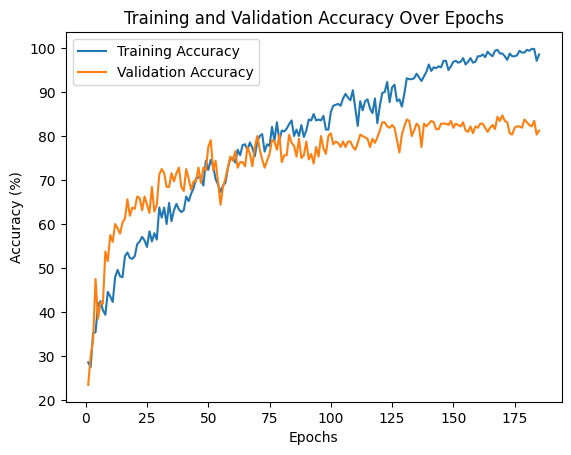

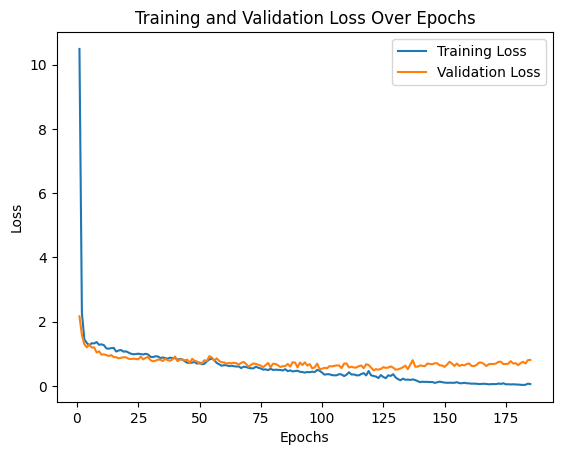

In [44]:
from tqdm import tqdm
import torch
import os

num_epochs = 50

best_model_path = "/kaggle/working/deep_finetune_best_model_2.pth"


prev_train_acc = prev_test_acc = prev_train_loss = prev_test_loss = None

# Training loop
for epoch in range(num_epochs):
    model_ft.train()
    running_loss = 0.0
    pbar = tqdm(test_dataloader_2, desc=f"Epoch {epoch+1}/{num_epochs}, Loss: 0.0000")

    pred_label = []
    true_label = []

    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)  
        optimizer.zero_grad() 
        outputs = model_ft(images) 
        
        _, predicted = torch.max(outputs.data, 1) 
        pred_label.extend(predicted.cpu().numpy())  
        true_label.extend(labels.cpu().numpy()) 

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()  

        running_loss += loss.item()  
        pbar.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(test_dataloader_2):.4f}") 

    # Calculate and print training accuracy
    train_correct = sum(p == t for p, t in zip(pred_label, true_label))
    train_accuracy = 100 * train_correct / len(true_label)
    train_acc.append(train_accuracy)
    epoches.append(epoch + 136)
    train_loss.append(running_loss/len(test_dataloader_2))

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(test_dataloader_2):.4f}, Training Accuracy: {train_accuracy:.2f}%')

    # Validation
    model_ft.eval() 
    correct = 0 
    total = 0 
    running_loss_test = 0
    with torch.no_grad(): 
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)  
            outputs = model_ft(images) 
            _, predicted = torch.max(outputs.data, 1) 
            total += labels.size(0) 
            correct += (predicted == labels).sum().item()  
            loss = criterion(outputs, labels)  
            running_loss_test += loss.item() 

    accuracy_test = 100 * correct / total
    test_acc.append(accuracy_test)
    test_loss.append(running_loss_test/len(test_dataloader))

    print(f'Validation Accuracy: {accuracy_test:.2f}%') 

    # Calculate convergence speed
    if prev_train_acc is not None:
        acc_conv_speed_train = train_accuracy - prev_train_acc
        acc_conv_speed_test = accuracy_test - prev_test_acc
        loss_conv_speed_train = prev_train_loss - train_loss[-1]
        loss_conv_speed_test = prev_test_loss - test_loss[-1]

        print(f'Convergence Speed - Training Accuracy: {acc_conv_speed_train:.4f}, Validation Accuracy: {acc_conv_speed_test:.4f}')
        print(f'Convergence Speed - Training Loss: {loss_conv_speed_train:.4f}, Validation Loss: {loss_conv_speed_test:.4f}')

    # Update previous epoch values
    prev_train_acc, prev_test_acc = train_accuracy, accuracy_test
    prev_train_loss, prev_test_loss = train_loss[-1], test_loss[-1]

    # Save best model if the validation accuracy improves
    if accuracy_test > best_accuracy:
        best_accuracy = accuracy_test
        os.makedirs( "/kaggle/working/", exist_ok=True)
        torch.save(model_ft.state_dict(), best_model_path)
        print(f"Best model saved with accuracy {best_accuracy:.2f}%")

import matplotlib.pyplot as plt

plt.plot(epoches, train_acc, label='Training Accuracy')
plt.plot(epoches, test_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

# Plot loss curves
plt.plot(epoches, train_loss, label='Training Loss')
plt.plot(epoches, test_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()


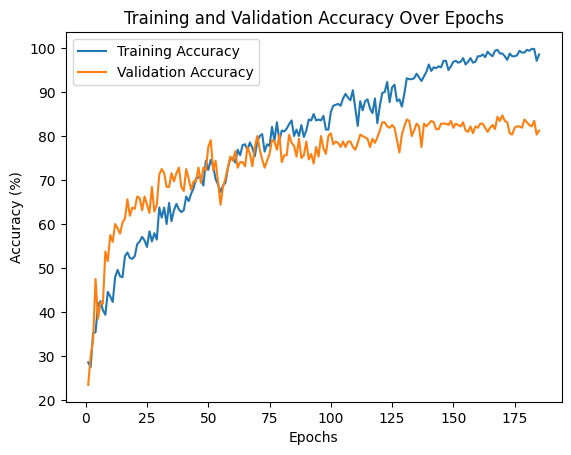

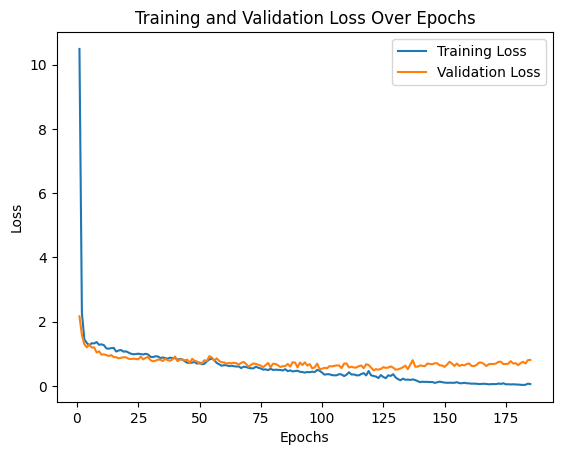

In [45]:
import matplotlib.pyplot as plt

plt.plot(epoches, train_acc, label='Training Accuracy')
plt.plot(epoches, test_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

# Plot loss curves
plt.plot(epoches, train_loss, label='Training Loss')
plt.plot(epoches, test_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()


/tmp/ipykernel_36/3623610877.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ft.load_state_dict(torch.load(best_model_path))
Testing: 100%|██████████| 10/10 [00:04

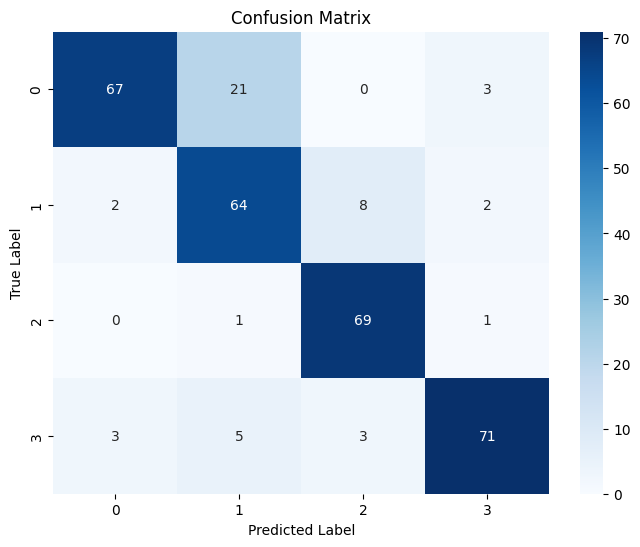

Classification Accuracy: 84.69%


In [46]:
import torch
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the best model for testing
model_ft.load_state_dict(torch.load(best_model_path))
model_ft.eval()

# Initialize lists for true and predicted labels
pred_label = []
true_label = []

# Testing loop
with torch.no_grad():
    pbar = tqdm(test_dataloader, desc="Testing")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model_ft(images)  # Forward pass
        _, predicted = torch.max(outputs.data, 1)  # Get predictions
        
        pred_label.extend(predicted.cpu().numpy())  # Save predictions
        true_label.extend(labels.cpu().numpy())  # Save true labels

# Calculate confusion matrix
cm = confusion_matrix(true_label, pred_label)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Optionally, print classification accuracy
accuracy = 100 * sum(p == t for p, t in zip(pred_label, true_label)) / len(true_label)
print(f'Classification Accuracy: {accuracy:.2f}%')


# For Shallow